[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-1/chain.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58238466-lesson-4-chain)

英文原版：https://github.com/langchain-ai/langchain-academy/tree/main

译者：Bryce Wang, brycewang2018@gmail.com

# 主题：Chain

## 回顾

在上一个 ipynb 中，我们创建了一个包含多个节点、普通边和条件边的一个简单图。

## Goals

现在，让我们创建一个简单的 chain，基于下面的 4 个概念 [concepts](https://python.langchain.com/v0.2/docs/concepts/):

* 用 [chat messages](https://python.langchain.com/v0.2/docs/concepts/#messages) 来当成 graph state（字典）
* 用 [chat models](https://python.langchain.com/v0.2/docs/concepts/#chat-models) 来建立节点（节点=基于大模型的函数）
* [Binding tools](https://python.langchain.com/v0.2/docs/concepts/#tools) - 为我们的大模型创建工具（工具=函数）
* [Executing tool calls](https://python.langchain.com/v0.2/docs/concepts/#functiontool-calling) - 在图的节点中执行工具

![Screenshot 2024-08-21 at 9.24.03 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dd607b08df5e1101_chain1.png)

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph

## Messages: 聊天记录

Chat models 可以使用 [`messages`](https://python.langchain.com/v0.2/docs/concepts/#messages)，用来记录对话中的不同角色。

LangChain 支持多种消息类型，包括 `HumanMessage`、`AIMessage`、`SystemMessage` 和 `ToolMessage`。

这些类型分别表示`来自用户的消息`、`来自聊天模型的消息`、`用于指导聊天模型行为的消息`，以及`来自工具调用的消息`。

我们来创建一组消息。

每条消息可以包含以下内容：

- `content` - 消息的内容
- `name` - 可选的，消息作者的名称
- `response_metadata` - 可选的，包含元数据的字典（例如，通常由模型提供商为 AIMessages 填充）

In [2]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

## 虚构一些人类用户和大模型 AI 的聊天记录
messages = [AIMessage(content=f"So you said you were researching ocean mammals?", name="Model")]
messages.append(HumanMessage(content=f"Yes, that's right.",name="Lance"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Lance

I want to learn about the best place to see Orcas in the US.


In [4]:
messages # 返回的是一个列表

[AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Model'),
 HumanMessage(content="Yes, that's right.", additional_kwargs={}, response_metadata={}, name='Lance'),
 AIMessage(content='Great, what would you like to learn about.', additional_kwargs={}, response_metadata={}, name='Model'),
 HumanMessage(content='I want to learn about the best place to see Orcas in the US.', additional_kwargs={}, response_metadata={}, name='Lance')]

In [7]:
messages[0].content # 类似于提取大模型聊天结果的内容

'So you said you were researching ocean mammals?'

## Chat Models：定义大模型

[Chat models](https://python.langchain.com/v0.2/docs/concepts/#chat-models) 可以把一系列的聊天记录当成 input，并且支持区分前面提到的 4 种不同的信息类型。

我们有 [多种选择](https://python.langchain.com/v0.2/docs/concepts/#chat-models) ，本案例的选择是 OpenAI. 

让我们核对下你的 `OPENAI_API_KEY` 是否设置成功，否则我们会让你再次输入。

In [8]:
## 检查并要求输入 OpenAI API 密钥
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

我们可以创建一个 Chat Model，并使用 messages 聊天记录列表来 invoke 它.

我们可以看到返回的结果，是一个带有 `response_metadata` 的 `AIMessage` 对象。

In [12]:
messages 

[AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Model'),
 HumanMessage(content="Yes, that's right.", additional_kwargs={}, response_metadata={}, name='Lance'),
 AIMessage(content='Great, what would you like to learn about.', additional_kwargs={}, response_metadata={}, name='Model'),
 HumanMessage(content='I want to learn about the best place to see Orcas in the US.', additional_kwargs={}, response_metadata={}, name='Lance')]

In [9]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")
result = llm.invoke(messages)
type(result)

langchain_core.messages.ai.AIMessage

In [10]:
result

AIMessage(content="One of the best places to see orcas in the United States is in the waters around the San Juan Islands in Washington State. These islands are located in the Pacific Northwest, near the Canadian border, and are renowned for their rich marine life, including orcas. The best time for orca watching in the San Juan Islands is typically from late spring through early fall, with the peak season being from May to September.\n\nIn addition to the San Juan Islands, other notable locations for orca sightings in the U.S. include:\n\n1. **Puget Sound, Washington**: Orcas, especially the Southern Resident orcas, can often be seen in Puget Sound. The waters around Seattle and Tacoma sometimes offer orca sightings.\n\n2. **Monterey Bay, California**: While primarily known for other marine mammals, orcas can occasionally be spotted in Monterey Bay, especially around April and May during their hunting of gray whale calves.\n\n3. **Southeast Alaska**: Though not part of the contiguous U

In [11]:
result.content 

"One of the best places to see orcas in the United States is in the waters around the San Juan Islands in Washington State. These islands are located in the Pacific Northwest, near the Canadian border, and are renowned for their rich marine life, including orcas. The best time for orca watching in the San Juan Islands is typically from late spring through early fall, with the peak season being from May to September.\n\nIn addition to the San Juan Islands, other notable locations for orca sightings in the U.S. include:\n\n1. **Puget Sound, Washington**: Orcas, especially the Southern Resident orcas, can often be seen in Puget Sound. The waters around Seattle and Tacoma sometimes offer orca sightings.\n\n2. **Monterey Bay, California**: While primarily known for other marine mammals, orcas can occasionally be spotted in Monterey Bay, especially around April and May during their hunting of gray whale calves.\n\n3. **Southeast Alaska**: Though not part of the contiguous U.S., Southeast Ala

In [13]:
result.response_metadata

{'token_usage': {'completion_tokens': 258,
  'prompt_tokens': 67,
  'total_tokens': 325,
  'completion_tokens_details': {'accepted_prediction_tokens': 0,
   'audio_tokens': 0,
   'reasoning_tokens': 0,
   'rejected_prediction_tokens': 0},
  'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}},
 'model_name': 'gpt-4o-2024-08-06',
 'system_fingerprint': 'fp_d28bcae782',
 'finish_reason': 'stop',
 'logprobs': None}

In [ ]:
## 基于空白的 messages 对象调用 invoke
llm.invoke(input="")  ## 返回的是类似于 ChatGPT 平时的打招呼信息

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 7, 'total_tokens': 17, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_d28bcae782', 'finish_reason': 'stop', 'logprobs': None}, id='run-88423622-a7ed-40dd-b069-d543275e8576-0', usage_metadata={'input_tokens': 7, 'output_tokens': 10, 'total_tokens': 17, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

## Tools：基于函数定义工具，供大模型调用并在节点执行

工具在需要模型与外部系统交互时非常有用。

外部系统（例如 API）通常需要特定的`输入格式或数据结构` (`input schema or payload`)，而不是自然语言。

当我们将一个 API `绑定为工具时，就会提示大模型该工具所需的输入格式`。

模型会`根据用户的自然语言输入，决定是否调用工具`。

同时，工具所返回的输出，将符合工具的规定格式（schema）。

[许多 LLM 供应商都支持 tool calling](https://python.langchain.com/v0.1/docs/integrations/chat/) 和 [tool calling interface](https://blog.langchain.dev/improving-core-tool-interfaces-and-docs-in-langchain/)，它们在 LangChain 中的定义是很简单的. 
 
你可以可以简单地给 `ChatModel.bind_tools(function)`，传递一个普通的 Python `函数`。

![Screenshot 2024-08-19 at 7.46.28 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dc1c17a7a57f9960_chain2.png)

下面我们会展示一个 tool calling 的简单案例。
 
这里我们的工具是 `multiply` 函数（工具=函数）。

In [16]:
## 定义一个函数 
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

## 绑定函数到 llm 对象
llm_with_tools = llm.bind_tools([multiply])

 如果我们给大模型传入一句话，比如，`"What is 2 multiplied by 3"`，我们可以得到一个 tool call。

这个 tool call， 会带匹配目标工具的 input schema 参数（`大模型在调用工具的时候，会自动生成运行工具函数的参数`）:

```
{'arguments': '{"a":2,"b":3}', 'name': 'multiply'}
```

In [ ]:
## 调用工具函数
tool_call = llm_with_tools.invoke([HumanMessage(content=f"What is 2 multiplied by 3", name="Lance")])
tool_call

## 再次说明：大模型决定了是否调用工具，并且如果决定调用，会返回执行工具函数所需要的参数

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_YPW8aFyk1nRKv3fd4HUcL767', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 62, 'total_tokens': 80, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_d28bcae782', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-3877704d-b0b2-4a2a-a1ba-f03e6c307263-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_YPW8aFyk1nRKv3fd4HUcL767', 'type': 'tool_call'}], usage_metadata={'input_tokens': 62, 'output_tokens': 18, 'total_tokens': 80, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [18]:
## 提取工具函数返回的参数
tool_call.additional_kwargs['tool_calls']

[{'id': 'call_YPW8aFyk1nRKv3fd4HUcL767',
  'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'},
  'type': 'function'}]

## 基于 messages 定义 state （=字典= input schema for all）


Let's define our state, `MessagesState`, as a `TypedDict` with a single key: `messages`.

`messages` is simply a list of messages, as we defined above (e.g., `HumanMessage`, etc).

有了这些基础，我们现在可以在我们的图状态（graph state）中使用 [`messages`](https://python.langchain.com/v0.2/docs/concepts/#messages)。

让我们将状态 `MessagesState` 定义为一个带有单一键 `messages` 的 `TypedDict` (state = 字典)。

`messages` 就是我们上面定义的一组消息（例如，`HumanMessage` 等）的列表。

In [19]:
## 基于 messages 定义 state
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage


##  AnyMessage 是用来表示消息的泛型类型。这是一种类型注解，表示 messages 列表中的元素可以是任何消息类型，
## 例如 HumanMessage, AIMessage, SystemMessage 或 ToolMessage 等
class MessagesState(TypedDict): # 之前我们定义的叫 State; LangGraph 其实自带有 MessageState，下面会正式介绍
    messages: list[AnyMessage]


## 对比一下我们之前定义的 state 字典
## 定义了一个名为 State 的类型
## 这个类型继承了 TypedDict，声明 State 的实例是一个字典
## 字典中必须包含一个键名为 graph_state，其值的类型必须是 str（TypeDict 的核心作用）
#class State(TypedDict):
#    graph_state: str  ## 对于 graph_state 这个键，其值必须是 str 类型

## Reducers: append 新信息，而不是 override
现在，我们遇到了一个小问题！

正如我们讨论的，每个节点都会为 state key `messages` 返回一个新值（字典中，默认会覆盖原来的值）。

而且，这个新值会覆盖[override](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) 之前的 messages 值。

随着图的运行，我们希望将消息追加**append** (而不是覆盖)到我们的 `messages` state key 中。

我们可以使用`归约函数`[reducer functions](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers),来解决这个问题。

归约函数允许我们，指定状态更新的执行方式。

如果未指定归约函数，则默认假定对键的更新是覆盖，正如我们之前看到的那样。

这里，为了追加消息，我们可以使用预构建的 `add_messages` 归约函数。

这可以确保任何新消息都被追加到现有的消息列表中。

我们只需通过元数据将 `add_messages` 归约函数，注解到 `messages 键`上即可。

In [22]:
from typing import Annotated
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

由于在图状态中拥有消息列表是如此常见，LangGraph 提供了一个预构建的 [`MessagesState`](https://langchain-ai.github.io/langgraph/concepts/low_level/#messagesstate)! 

`MessagesState` 的定义如下：

- 内置了一个单一的 `messages` 键
- 这是一个由 `AnyMessage` 对象组成的列表
- 使用了 `add_messages` 归约函数
- 我们通常会使用 `MessagesState`，因为它比自定义 `TypedDict` 的方式更简洁。

In [23]:
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    pass

更深入一点，我们可以单独看看 `add_messages` 归约函数是如何工作的。

In [24]:
# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='eb313cae-e1d9-40ef-a43c-e65345ef5e73'),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Lance', id='d6397750-5cf1-4a6e-9aa1-3eadd2ce5b8a'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='590421b6-4219-484f-9ee3-6606b8c3d144')]

## 创建图

现在，让我们使用 `MessagesState` 创建一个图。

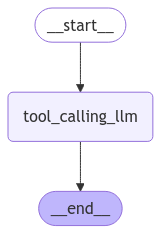

In [25]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
    
# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState) 
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

If we pass in `Hello!`, the LLM responds without any tool calls.

In [26]:
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

Hi there! How can I assist you today?


The LLM chooses to use a tool when it determines that the input or task requires the functionality provided by that tool.

In [27]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 2 and 3")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_nRrHkMgtWJvWAPHiKtuYyi9d)
 Call ID: call_nRrHkMgtWJvWAPHiKtuYyi9d
  Args:
    a: 2
    b: 3


In [ ]:
## 后面的 notebook，会介绍如何执行工具函数，并返回结果
# END